In [1]:
import numpy as np
import pandas as pd
import altair as alt

# Exercise 1

Consider the polynomial expression

$p(x) = a_0 + a_1x + a_2x^2 + ...a_nx^n = \sum_{i=0}^{n} a_ix^i$

Earlier, you wrote a simple function `p(x, coeff)` to evaluate it without considering efficiency.

Now write a new function that does the same job, but uses NumPy arrays and array operations for its computations, rather than any form of Python loop

(Such functionality is already implemented as `np.poly1d`, but for the sake of the exercise don't use this class)

- Hint: Use `np.cumprod()`

In [2]:
# without cumprod first since that's how I first thought about it
def p1(x, coeff):
    a = np.asarray(coeff)
    exp = x ** np.arange(0, len(a))
    return a @ exp

In [3]:
def p(x, coeff):
    a = np.asarray(coeff)
    X = np.empty(len(coeff))
    X[0] = 1
    X[1:] = x
    X = np.cumprod(X)
    return a @ X

# Exercise 2

Let `q` be a NumPy array of length `n` with `q.sum() == 1`

Suppose that `q` represents a [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function)

We wish to generate a discrete random variable $x$ such that $\mathbb{P}\{x=i\}=q_i$

In other words, `x` takes values in `range(len(q))` and `x = i` with probability `q[i]`

The standard (inverse transform algorithm is as follows:

- Divide the unit interval $[0,1]$ into $n$ subintervals $I_0, I_1,...,I_{n-1}$ such that the length of $I_i$ is $q_i$

- Draw a uniform random variable $U$ on $[0,1]$ and return the $i$ such that $U \in I_i$

The probability of drawing $i$ is the length of $I_i$, which is equal to $q_i$

We can implement the algorithm as follows

```python
from random import uniform

def sample(q):
    a = 0.0
    U = uniform(0, 1)
    for i in range(len(q)):
        if a < U <= a + q[i]:
            return i
        a = a + q[i]
```

If you can't see how this works, try thinking through the flow for a simple example, such as `q = [0.25, 0.75]` it helps to sketch the intervals on paper.

Your exercise is to speed it up using NumPy, avoiding explicit loops

- Hint: Use `np.searchsorted` and `np.cumsum`

If you can, implement the functionality as a class called `discreteRV`, where

- the data for an instance of the class is the vector of probabilities `q`

- the class has a `draw()` method, which returns one draw according to the algorithm described above

If you can, write the method so that `draw(k)` returns `k` draws from `q`

In [4]:
class DiscreteRV:
    
    def __init__(self, q):
        if sum(q) != 1:
            raise ValueError('q must sum to 1')
        self._q = np.cumsum(np.asarray(q))
    
    def __len__(self):
        return len(self._q)
    
    def __call__(self):
        return self._q
    
    def draw(self, k=1):
        if not isinstance(k, int):
            print('k must be an integer')
            return None
        if not k > 0:
            print('k must be positive')
        uniform_draws = np.random.uniform(size=k)
        return np.searchsorted(self._q, uniform_draws)
        

In [5]:
r = DiscreteRV([0.01, 0.08, 0.01, 0.2, 0.3, 0.15, 0.15, 0.1])
print(r())
print(r.draw(3))

[0.01 0.09 0.1  0.3  0.6  0.75 0.9  1.  ]
[3 7 5]


# Exercise 3



Recall our [earlier discussion](https://lectures.quantecon.org/py/python_oop.html#oop-ex1) of the empirical cumulative distribution function

Your task is to

1. Make the `__call__` method more efficient using NumPy
2. Add a method that plots the ECDF over $[a,b]$, where $a$ and $b$ are method parameters

In [6]:
class ECDF:
    """Empirical cumulative distribution function"""
    
    def __init__(self, samples):
        self.samples = np.asarray(samples)
        self.samples.sort()
    
    def f(self, x):
        n = len(self.samples)
        below = np.searchsorted(self.samples, x)
        return below / n
    
    def __call__(self, x):
        return self.f(x)
    
    def graph(self, a, b):
        x = np.linspace(start=a, stop=b, num=100)
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        cht = (
            alt.Chart(df)
            .mark_line()
            .encode(
                x=alt.X('x:Q', axis=alt.Axis(format=".2f")),
                y='y:Q'
            )
            .properties(width=400)
        )
        return cht

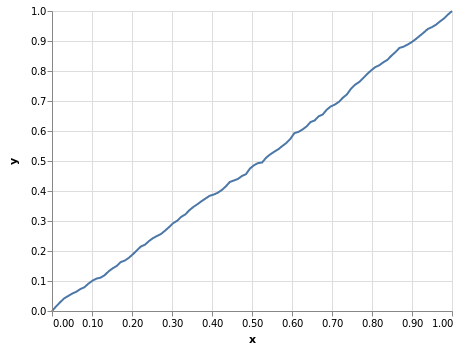

In [7]:
f= ECDF(np.random.uniform(size=1000))
f.graph(0, 1)